# Libs Import

In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [4]:
import os
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

___
# 1) Activation functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


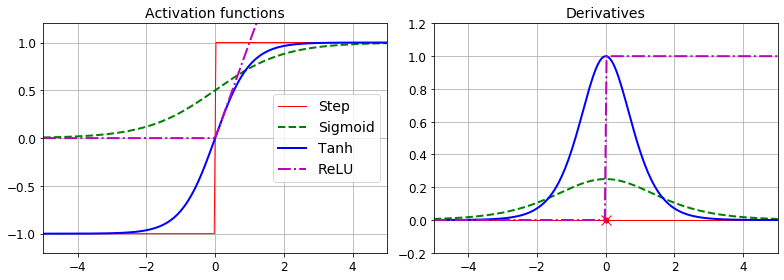

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

___
# 2) Classification using Sequential API

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets` <br>
> The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Unlinke Sci-Kit Learn's MNIST and Fashion MNIST, Keras MNIST and Fashion MNIST has each image of 28x28 pixels, rather than a 1d array of size 784(28*28=784)<br>
Also, pixel intensity is represented by int dtype, rather than float

In [8]:
print(X_train_full.shape); 
print(f"Each pixel intensity is represented as a byte (0 to 255):")
print(X_train_full.dtype)

(60000, 28, 28)
Each pixel intensity is represented as a byte (0 to 255):
uint8


Let's split the full training set into a validation set and a (smaller) training set<br>
We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [10]:
print(X_valid.shape); print(X_test.shape)

(5000, 28, 28)
(10000, 28, 28)


In MNIST, label 5 means image represents digit 5 <br>
However, in Fashion MNIST, we need to have a list of class names, in order to understand what the image represents, e.g.

In [11]:
print(f"Values in y_train: {y_train}")
print(f"y_train[0]: {y_train[0]}; y_train[1]: {y_train[1]} and so on.....")
print(f"List of unique Class IDs, or labels: {np.unique(y_train)}")

Values in y_train: [4 0 7 ... 3 0 5]
y_train[0]: 4; y_train[1]: 0 and so on.....
List of unique Class IDs, or labels: [0 1 2 3 4 5 6 7 8 9]


Here are the corresponding class names:

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
print(f"Since y_train[0] is {y_train[0]}")
print(f"First image in y_train represents: {class_names[y_train[0]]}")

Since y_train[0] is 4
First image in y_train represents: Coat


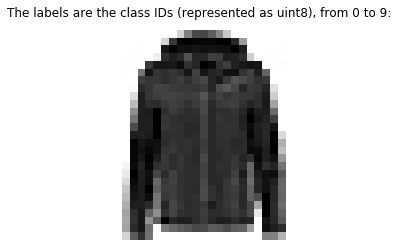

In [13]:
plt.imshow(X_train[0], cmap="binary") # 'binary' color-map
plt.axis('off')
plt.title("The labels are the class IDs (represented as uint8), from 0 to 9:")
plt.show()

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


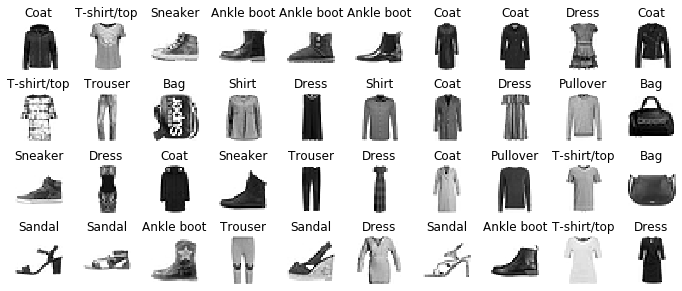

In [14]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

___
### Creating model using Sequential API
Now lets build a neural network <br>
Below is a MLP with 2 hidden layers

In [15]:
model = keras.models.Sequential() #creates a Sequential model, i.e. Single stack of layers connected sequentially
model.add(keras.layers.Flatten(input_shape=[28, 28])) # 1st layer, and it "flattens" the i/p, i.e. convert each i/p image to a 1D array (computes X.reshape(-1,1))
model.add(keras.layers.Dense(300, activation="relu")) # Hidden layer with ReLU activation function
model.add(keras.layers.Dense(100, activation="relu")) # Hidden layer with ReLU activation function
model.add(keras.layers.Dense(10, activation="softmax")) # since 10 unique class in y_train, we use an o/p layer with 10 neurons
# Also, O/P layer has Softmax Activation Function, as the classes are Exclusive in nature
# List of other Activation function provided by Keras: https://keras.io/api/layers/activations/

Another way of writting same code, above, is by passing the layers as a list of tuple to Sequential

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.layers

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


___
- 1st col tells about the column name (default name, unless explicitly specified)
- 2nd col tells about the O/P shape, (none means batch size could be anything)
- 3rd col tells about the number of parameters
___
<b>Params Calculation</b>: <br>
1st hidden layer:
```python
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
```
When `input_shape=[28, 28]` is in previous layer and `300 neurons` in current layer <br>
I.e. $28*28*300$ connection weights, + 300 bias terms <br>
Total Params = $(28*28*300)+300 = 2,35,500$ 

### Getting model's individual layer:

In [19]:
model.layers

In [20]:
ip_layer = model.layers[0]
hidden1 = model.layers[1]
hidden2 = model.layers[2]
print(hidden1.name)

dense


In [21]:
model.get_layer('dense') is hidden1

True

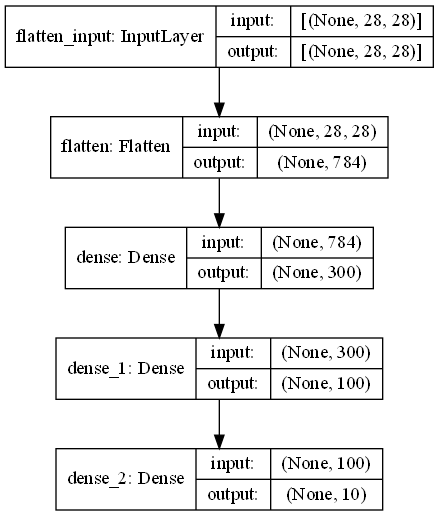

In [22]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

___
A model's weights and biases can be retrived using `.get_weights()`

In [23]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [24]:
weights.shape # Equivalent to I/P feature * number of neurons in that layer, i.e. ((28*28)*300)

(784, 300)

In [25]:
print(biases.shape) # Equivalent to number of neurons in that layer, i.e. 300

(300,)


### Compiling the Model

In [26]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

Or, 
```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

### Training & Evaluation

In [27]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
# I/P Features = X_train
# Target Class = y_train
# Default Epochs = 1
# Validation_Data = optional
# Instead of passing "validation_data", "validation_split" parameter can be  specified, e.g.
# E.g. model.fit(X_train, y_train, epochs=30, validation_split=0.1) for 10% of the data to be used for validation

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4393 - accuracy: 0.8454 - val_loss: 0.5330 - val_accuracy: 0.7980
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4125 - accuracy: 0.8569 - val_loss: 0.3915 - val_accuracy: 0.8644
Epoch 5/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3940 - accuracy: 0.8619 - val_loss: 0.3748 - val_accuracy: 0.8690
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3752 - accuracy: 0.8674 - val_loss: 0.3707 - val_accuracy: 0.8722
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3633 - accuracy: 0.8714 - val_loss: 0.3627 - val_accuracy:

In [28]:
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Saving figure keras_learning_curves_plot


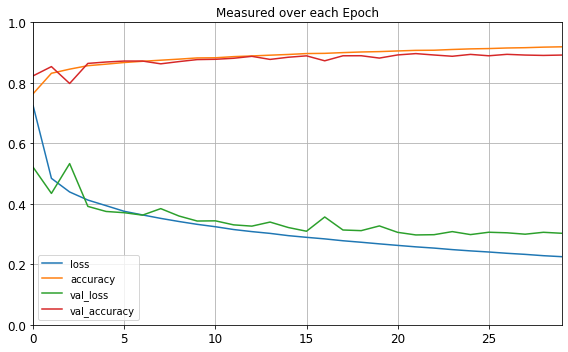

In [29]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Measured over each Epoch")
save_fig("keras_learning_curves_plot")
plt.show()

___
### Hyperparameter Tuning
- Learning Rate
- Number of Layers
- Number of Neurons per layer
- Activation Functions for each hidden layer
- Batch Size

___
### Model Evaluation

In [30]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3361 - accuracy: 0.8834


[0.3360535800457001, 0.883400022983551]

___
### Model Prediction

#### Predicting only highest estimated probability

In [31]:
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.11, 0.  , 0.01, 0.  , 0.01, 0.  , 0.87, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.89, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

<b>Model estimates that</b><br>
- For 1st instance, the probability of the instance belonging to class-9 is 100%
- For 5th instance, the probability of the instance belonging to class-1 is 14% and class-6 is 86%

#### Predicting only highest estimated probability

In [32]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)

[9 2 1 1 6 1 4 6 5 7]


[9 2 1 1 6 1 4 6 5 7]
Saving figure fashion_mnist_images_plot


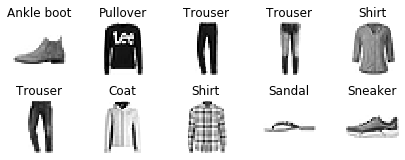

In [33]:
# Looking at actual values
y_new = y_test[:10]
print(y_new)

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

In [34]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

___
# 3) Regression

## 3.1) Regression using Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [35]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [40]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - val_loss: 0.4656

In [41]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 760us/step - loss: 0.4212


In [42]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

In [43]:
print(y_pred)

[[0.38856643]
 [1.6792021 ]
 [3.1022794 ]]


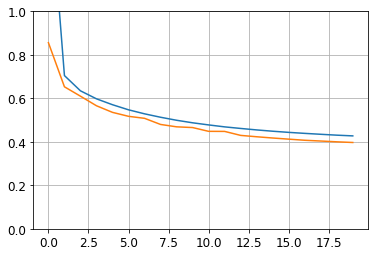

In [44]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 3.2) Regression using Functional API

Not all neural network models are simply sequential. A Wide & Deep neural network ([see paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

### Wide & Deep Neural Network
- Wide & Deep Neural Network connects all or part of inputs directly to the o/p layer 
- This helps the network to learn both, deep patterns(using deep path) and also simple rules(using wide or short path)
<br>

<img src="./imgs/Wide_&_Deep_NN.png" width="300"></img>

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

```python
input_  = keras.layers.Input(shape=X_train.shape[1:])
```
> Input Object created, which will carry shape and dtype information

```python
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
```
> A Dense layer with 30 neurons and ReLU activation function created, to whom previous layer is passed, as if it were a function

```python
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
```
> Another Dense layer with 30 neurons and ReLU activation function created, to whom previous layer is passed

```python
concat  = keras.layers.concatenate([input_, hidden2])
```
> Next we create concatenate layer, used as a function, to concatenate i/p and o/p of 2nd hidden layer

```python
output  = keras.layers.Dense(1)(concat)
```
> Finally, an O/P layer, with single neuron & no activation function(regression problem) <br>
> And using the layer as a function, passing result of concatenation

```python
model   = keras.models.Model(inputs=[input_], outputs=[output])
```
> Lastly, a Keras model, to specify i/ps and o/ps to be used

In [46]:
X_train.shape[1:]

(8,)

In [47]:
input_  = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat  = keras.layers.concatenate([input_, hidden2])
output  = keras.layers.Dense(1)(concat)
model   = keras.models.Model(inputs=[input_], outputs=[output])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [49]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4659 - val_loss: 0.4313

#### <b>3.2.a) Multiple Inputs </b>:
- What if you want to send different subsets of input features through the wide or deep paths? <br>
- We will send 5 features (features 0 to 4) through wide path, and 6 through the deep path (features 2 to 7)<br> 
- Note that 3 features will go through both (features 2, 3 and 4)

> Since X_train.shape[1] is 7
```python
X_train_wide_path, X_train_B_deep_path = X_train[:, :5], X_train[:, 2:]
```

<img src="./imgs/Multiple_Inputs.png" width="300"></img>

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [52]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4644 - val_loss: 0.4315

In [53]:
y_pred

array([[0.30591232],
       [1.9540672 ],
       [3.4426107 ]], dtype=float32)

#### <b>3.2.b) Multiple Outputs </b>
<b>Reasons for having Multiple Output neural network</b>:
- Task Dependent: Task is to find an object in an image, and to locate it
- Multitask Classification: 2 separate task (e.g. mood classification and head accessory identifier)
- Regularization: Adding auxilary o/ps as a trainingconstraint


<img src="./imgs/Multiple_Outputs.png" width="300"></img>

Below code builds the network represented in above figure:

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
# Same as above code, till...
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])

In [56]:
# Adding Auxilary Node along with Output Node:
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [57]:
# Since main output node is more imp than aux node, former will get more weight then later
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [58]:
# Each o/p node should be provided individual labe;
# Since here both are predicting same, we can pass y_train twice
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [59]:
# Keras will return total, as well as individual loss
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


In [60]:
# Also, pred for eacj o/p
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

## 3.3) Regression using Subclassing API

- Functional and Sequential API are declarative, i.e. static in nature and can't be dynamic in nature

In [61]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [62]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

In [63]:
model = WideAndDeepModel(30, activation="relu") # Using subclassing API

___
# 4) Saving and Restoring a Model

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [66]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 720us/step - loss: 0.4382


In [67]:
model.save("./my_keras_model.h5")
model.save("./saving_keras_model.h5")

<b>Keras will use HDF5 format to save</b>:
- Model's Architecture (every layer's hyperparameters)
- Values of model parameters, for each layer (i.e. connection weights & biases)
- Optimizer

In [68]:
tf.__version__

'2.6.0'

In [69]:
model = keras.models.load_model("./saving_keras_model.h5")

In [70]:
X_new = X_test[:3]
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [71]:
model.save_weights("saving_keras_weights.ckpt")

In [72]:
model.load_weights("saving_keras_weights.ckpt")

## 4.1) Using Callbacks during Training¶

In [73]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [74]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [75]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                                                save_best_only=True) # Save Best Only is set to "True"
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 817us/step - loss: 0.4382


In [76]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                                                save_best_only=True) # Save Best Only is set to "True"
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, #Patience: number of epochs for early stopping
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb]) 
# Number of epochs is set to 100 (large value), As training will stop automatically, if model isn't improving, as early stop is applied
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3976 - val_lo

## 4.2) Custom Callbacks

Custom Callback for ratio between Validation Loss & Training Loss

In [77]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [78]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 0s 1ms/step - loss: 0.3302 - val_loss: 0.3559

val/train: 1.08


# 5) Tensorboard

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [81]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [82]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_callback])

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4474 - val_loss: 0.4379

___
You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

In [83]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10068), started 0:28:40 ago. (Use '!kill 10068' to kill it.)

___
# 6) Hyperparameter Tuning